[I 2025-06-28 21:32:17,916] A new study created in memory with name: no-name-7e47868e-673f-4986-95c4-1148d69e958b
[I 2025-06-28 21:32:30,139] Trial 0 finished with value: 76164.51284512058 and parameters: {'max_depth': 9, 'learning_rate': 0.11485817777329588, 'n_estimators': 587, 'subsample': 0.5622017875064298, 'colsample_bytree': 0.8792773804608705, 'reg_alpha': 0.22280464430696678, 'reg_lambda': 0.5293595284417802, 'min_child_weight': 4.54955677491586, 'gamma': 2.6622109743420563}. Best is trial 0 with value: 76164.51284512058.
[I 2025-06-28 21:32:38,690] Trial 1 finished with value: 73423.42019564853 and parameters: {'max_depth': 8, 'learning_rate': 0.07099463965738825, 'n_estimators': 491, 'subsample': 0.7599541964156933, 'colsample_bytree': 0.905191021024127, 'reg_alpha': 0.014356360256462364, 'reg_lambda': 0.778474699200763, 'min_child_weight': 9.192097947555494, 'gamma': 1.3741193243649135}. Best is trial 1 with value: 73423.42019564853.
[I 2025-06-28 21:32:51,294] Trial 2 fini

Evaluation – XGBoost + Optuna CV (All Features)
  MAE:  26,003.26 €
  RMSE: 35,291.24 €
  R²:   0.9505
----------------------------------------
Evaluation – XGBoost + Optuna CV (Top RF Features)
  MAE:  43,264.27 €
  RMSE: 58,627.78 €
  R²:   0.8634
----------------------------------------
Model evaluation for 'XGBoost + Optuna CV (All Features)' already exists. Skipping log.
Model evaluation for 'XGBoost + Optuna CV (Top RF Features)' already exists. Skipping log.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,best,type,rank_r2,rmse/mae
0,1,2025-06-28 20:31:45,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,Linear Regression (All Features),202506282030,65 799.62 €,88 451.34 €,0.694200,,Linear,5,1.340000
1,2,2025-06-28 20:32:13,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,Random Forest (All Features),202506282030,58 707.58 €,81 427.37 €,0.740800,,Tree,3,1.390000
2,3,2025-06-28 20:32:20,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,Random Forest (Top 10 Features),202506282030,62 573.35 €,85 890.72 €,0.711600,,Tree,4,1.370000
3,4,2025-06-28 20:50:52,XGBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,XGBoost with Optuna (All Features),202506282030,15 627.01 €,21 892.36 €,0.981000,✓,Boosting,1,1.400000
4,5,2025-06-28 20:50:52,XGBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,XGBoost with Optuna (Top RF Features),202506282030,36 914.65 €,49 743.83 €,0.901700,,Boosting,2,1.350000



👉 Best model based on R²: XGBoost + Optuna CV (All Features) ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,best,type,rank_r2,rmse/mae
0,1,2025-06-28 20:31:45,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,Linear Regression (All Features),202506282030,65 799.62 €,88 451.34 €,0.694200,,Linear,5,1.340000
1,2,2025-06-28 20:32:13,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,Random Forest (All Features),202506282030,58 707.58 €,81 427.37 €,0.740800,,Tree,3,1.390000
2,3,2025-06-28 20:32:20,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,Random Forest (Top 10 Features),202506282030,62 573.35 €,85 890.72 €,0.711600,,Tree,4,1.370000
3,4,2025-06-28 20:50:52,XGBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,XGBoost with Optuna (All Features),202506282030,15 627.01 €,21 892.36 €,0.981000,✓,Boosting,1,1.400000
4,5,2025-06-28 20:50:52,XGBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250628_2030.csv,XGBoost with Optuna (Top RF Features),202506282030,36 914.65 €,49 743.83 €,0.901700,,Boosting,2,1.350000



👉 Best model based on R²: XGBoost + Optuna CV (All Features) ✓
Diagnostics (All Features):


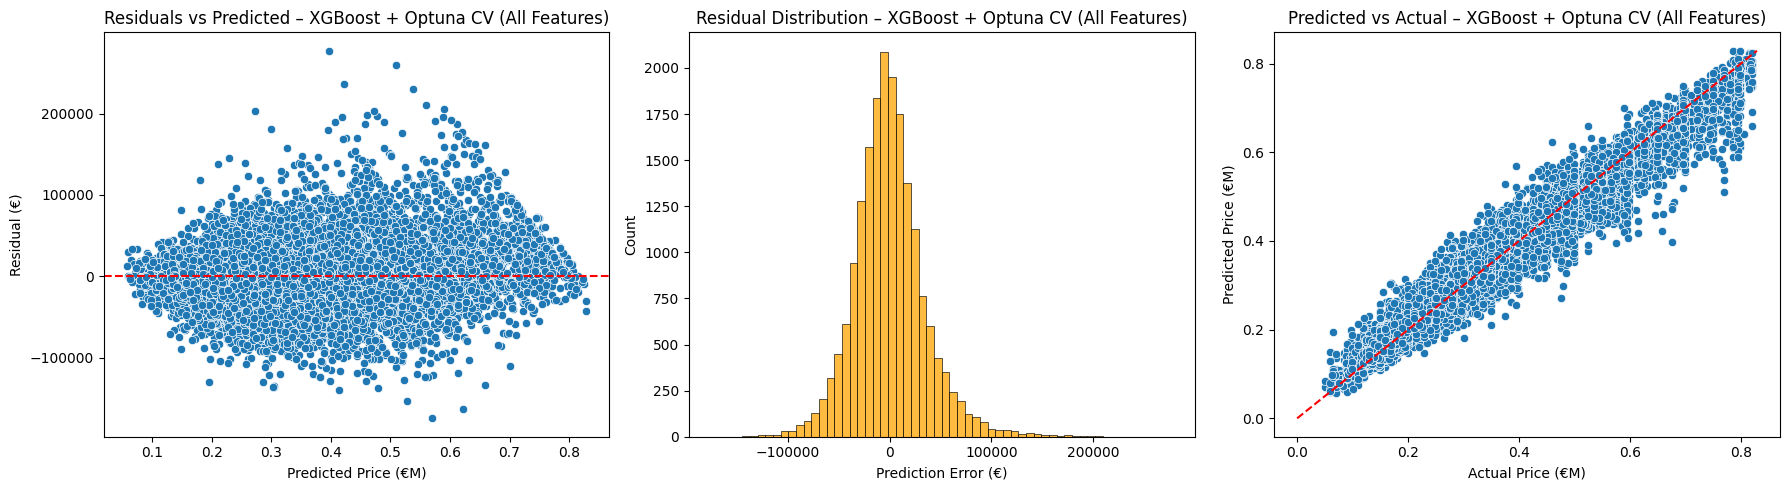

Diagnostics (Top RF Features):


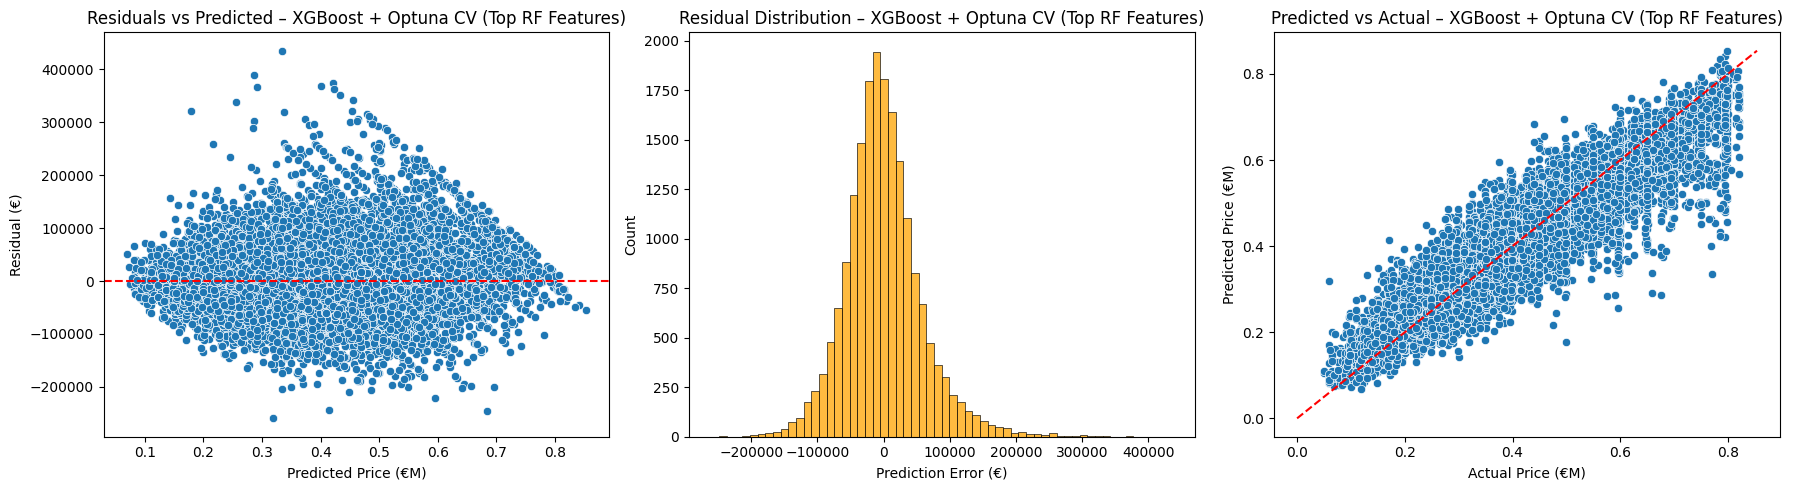

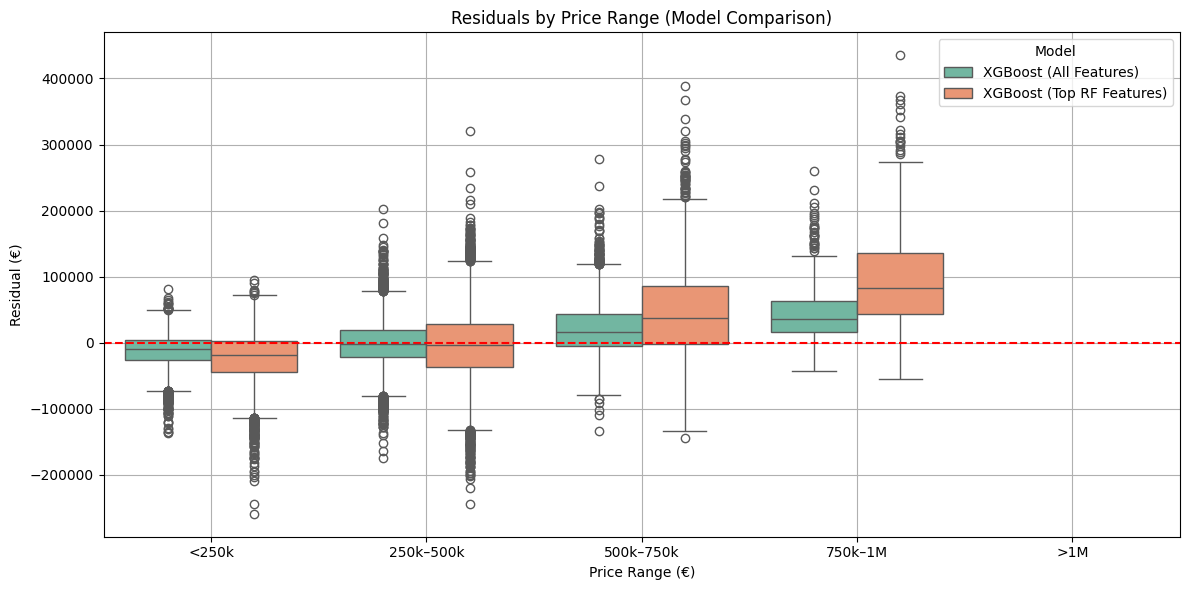

100%|===================| 19009/19013 [03:41<00:00]        

TypeError: beeswarm() got an unexpected keyword argument 'ax'

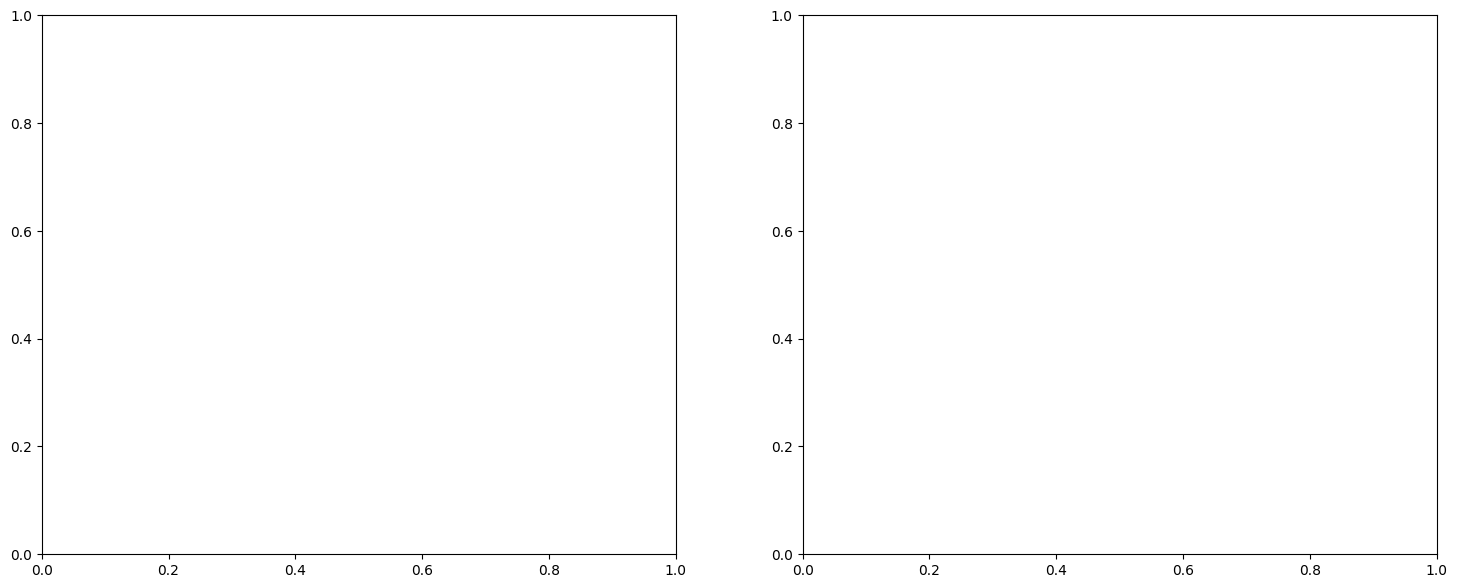

In [ ]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer

import numpy as np
import pandas as pd


# Root Mean Squared Error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()

X = df.drop(columns=["price"])
y = df["price"]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)  # Fit the selector on the full dataset
X_reduced = X.loc[:, selector.get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_all.fit(X_reduced, y)

importances = rf_model_all.feature_importances_
feature_ranking = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False)
top_features = feature_ranking.head(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna tuning function
def tune_xgboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
        }
        model = xgb.XGBRegressor(**params, objective="reg:squarederror", random_state=42, n_jobs=-1)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = -cross_val_score(model, X_data, y_data, scoring="neg_root_mean_squared_error", cv=cv)
        return scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study


# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

study_all = tune_xgboost_with_optuna(X_reduced, y, n_trials=n_trials)
model_all = xgb.XGBRegressor(**study_all.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

study_top = tune_xgboost_with_optuna(X_top, y, n_trials=n_trials)
model_top = xgb.XGBRegressor(**study_top.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluate models
evaluator_all = ModelEvaluator("XGBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("XGBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
tracker = ExperimentTracker()
df_metrics_all = tracker.log_and_get_evaluations(
    model="XGBoost + Optuna CV (All Features)",
    experiment="XGBoost with Optuna (All Features)",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

df_metrics_top = tracker.log_and_get_evaluations(
    model="XGBoost + Optuna CV (Top RF Features)",
    experiment="XGBoost with Optuna (Top RF Features)",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Display evaluation summary
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

# Step 9: Visual diagnostics
print("Diagnostics (All Features):")
visualizer_all = ModelVisualizer(model_all, X_reduced, y, model_name="XGBoost + Optuna CV (All Features)")
visualizer_all.plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
visualizer_top = ModelVisualizer(model_top, X_top, y, model_name="XGBoost + Optuna CV (Top RF Features)")
visualizer_top.plot_all_diagnostics()


ModelEvaluator.plot_price_range_residuals_side_by_side(
    y,
    y_pred_all,
    y_pred_top,
    model_names=("XGBoost (All Features)", "XGBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""

100%|===================| 18999/19013 [03:41<00:00]        

TypeError: beeswarm() got an unexpected keyword argument 'ax'

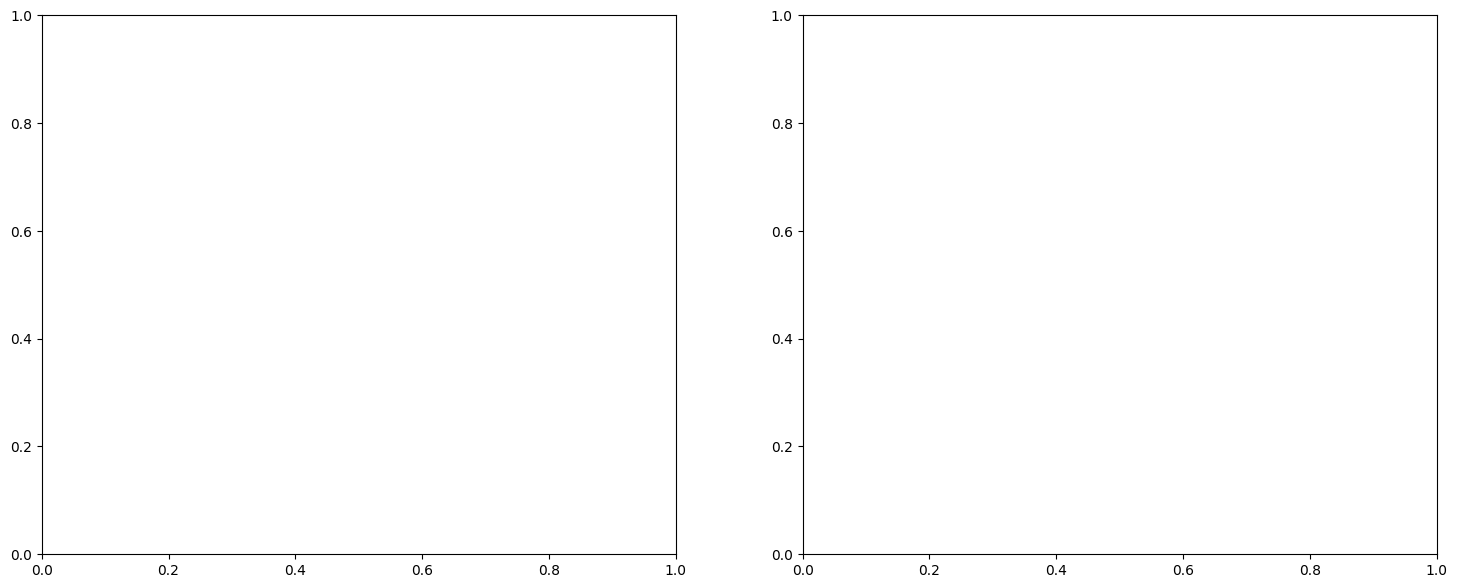

In [ ]:
def plot_shap_comparison_beeswarm(model_all, x_all, model_top, x_top):
    import shap
    import matplotlib.pyplot as plt

    explainer_all = shap.Explainer(model_all)
    explainer_top = shap.Explainer(model_top)

    shap_values_all = explainer_all(x_all)
    shap_values_top = explainer_top(x_top)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    shap.plots.beeswarm(shap_values_all, max_display=15, show=False)
    plt.title("SHAP Summary – All Features", fontsize=13)
    

    plt.subplot(1, 2, 2)
    shap.plots.beeswarm(shap_values_top, max_display=15, show=False)
    plt.title("SHAP Summary – Top RF Features", fontsize=13)

    plt.tight_layout()
    plt.show()

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""